In [1]:
#%matplotlib
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import math, gillespy2
from gillespy2.solvers.cpp.ssa_c_solver import SSACSolver
from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver
from gillespy2.solvers.numpy.basic_ivp_solver import BasicIVPSolver
from scipy import stats

In [2]:
class DayModel(gillespy2.Model):
    def __init__(self, parameter_values=None, init_v=0, spore=1.61e9, macrophage=1e6):
        # initialize
        gillespy2.Model.__init__(self, name="Macrophage")
        
        # species
        #S_ = gillespy2.Species(name='S_', initial_value=3.256e6) # low = 4e3; mid = 2e4; high = 1e7
        S_ = gillespy2.Species(name='S_', initial_value=spore) # low = 4e3; mid = 2e4; high = 1e7
        
        #A_ = gillespy2.Species(name='A_', initial_value=1e6) # A = Sa/(k2*S+MuA)
        A_ = gillespy2.Species(name='A_', initial_value=macrophage) # A = Sa/(k2*S+MuA)
        
        H1 = gillespy2.Species(name='H1', initial_value=0)
        H2 = gillespy2.Species(name='H2', initial_value=0)
        H3 = gillespy2.Species(name='H3', initial_value=0)
        H4 = gillespy2.Species(name='H4', initial_value=0)
        H5 = gillespy2.Species(name='H5', initial_value=0)
        H6 = gillespy2.Species(name='H6', initial_value=0)
        
        HLN1 = gillespy2.Species(name='HLN1', initial_value=0)
        HLN2 = gillespy2.Species(name='HLN2', initial_value=0)
        HLN3 = gillespy2.Species(name='HLN3', initial_value=0)
        HLN4 = gillespy2.Species(name='HLN4', initial_value=0)
        HLN5 = gillespy2.Species(name='HLN5', initial_value=0)
        HLN6 = gillespy2.Species(name='HLN6', initial_value=0)
        
        self.add_species([S_,A_,H1,H2,H3,H4,H5,H6,HLN1,HLN2,HLN3,HLN4,HLN5,HLN6])
        
        # parameters        
        # rate of phagocytosis
        k2 = gillespy2.Parameter(name='k2', expression=1e-10)
        
        # migration to TMLN
        k3 = gillespy2.Parameter(name='k3', expression=0.05)
        
        self.add_parameter([k2,k3])
        
        # reactions
        R1 = gillespy2.Reaction(
            name='R1',
            reactants={S_:1, A_:1},
            products={H1:1},
            rate=k2
        )
        
        R2 = gillespy2.Reaction(
            name='R2',
            reactants={S_:1, H1:1},
            products={H2:1},
            rate=k2
        )
        
        R3 = gillespy2.Reaction(
            name='R3',
            reactants={S_:1, H2:1},
            products={H3:1},
            rate=k2
        )
        
        R4 = gillespy2.Reaction(
            name='R4',
            reactants={S_:1, H3:1},
            products={H4:1},
            rate=k2
        )
        
        R5 = gillespy2.Reaction(
            name='R5',
            reactants={S_:1, H4:1},
            products={H5:1},
            rate=k2
        )
        
        R6 = gillespy2.Reaction(
            name='R6',
            reactants={S_:1, H5:1},
            products={H6:1},
            rate=k2
        )
        
        # To the lung
        R7 = gillespy2.Reaction(
            name='R7',
            reactants={H1:1},
            products={HLN1:1},
            rate=k3
        )
        
        R8 = gillespy2.Reaction(
            name='R8',
            reactants={H2:1},
            products={HLN2:1},
            rate=k3
        )
        
        R9 = gillespy2.Reaction(
            name='R9',
            reactants={H3:1},
            products={HLN3:1},
            rate=k3
        )
        
        R10 = gillespy2.Reaction(
            name='R10',
            reactants={H4:1},
            products={HLN4:1},
            rate=k3
        )
        
        R11 = gillespy2.Reaction(
            name='R11',
            reactants={H5:1},
            products={HLN5:1},
            rate=k3
        )
        
        R12 = gillespy2.Reaction(
            name='R12',
            reactants={H6:1},
            products={HLN6:1},
            rate=k3
        )
                
        self.add_reaction([R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12])
        t = numpy.linspace(0,200,21)
        self.timespan(t)
        #print(t)

In [3]:
def get_mean(results):
    num =  (
        (1*results['HLN1'][-1]) +
        (2*results['HLN2'][-1]) +
        (3*results['HLN3'][-1]) +
        (4*results['HLN4'][-1]) +
        (5*results['HLN5'][-1]) +
        (6*results['HLN6'][-1])
    )

    div = (
        results['HLN1'][-1] +
        results['HLN2'][-1] +
        results['HLN3'][-1] +
        results['HLN4'][-1] +
        results['HLN5'][-1] +
        results['HLN6'][-1]
    )
    
    weighted_avg = num / div
    return weighted_avg

def get_std(results):
    num =  (
        (1*results['HLN1'][-1]) +
        (2*results['HLN2'][-1]) +
        (3*results['HLN3'][-1]) +
        (4*results['HLN4'][-1]) +
        (5*results['HLN5'][-1]) +
        (6*results['HLN6'][-1])
    )
    
    num_sq =  (
        (1*results['HLN1'][-1]) +
        (4*results['HLN2'][-1]) +
        (9*results['HLN3'][-1]) +
        (16*results['HLN4'][-1]) +
        (25*results['HLN5'][-1]) +
        (36*results['HLN6'][-1])
    )

    div = (
        results['HLN1'][-1] +
        results['HLN2'][-1] +
        results['HLN3'][-1] +
        results['HLN4'][-1] +
        results['HLN5'][-1] +
        results['HLN6'][-1]
    )
    
    weighted_avg = num / div
    var_x = (num_sq / div) - weighted_avg**2
    return numpy.sqrt(var_x)

def get_sem(results):
    n = (
        results['HLN1'][-1] +
        results['HLN2'][-1] +
        results['HLN3'][-1] +
        results['HLN4'][-1] +
        results['HLN5'][-1] +
        results['HLN6'][-1]
    )
    return get_std(results)/numpy.sqrt(n)

Wall time: 137 ms
Wall time: 0 ns
5.891954818687327


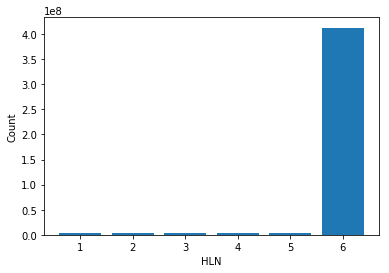

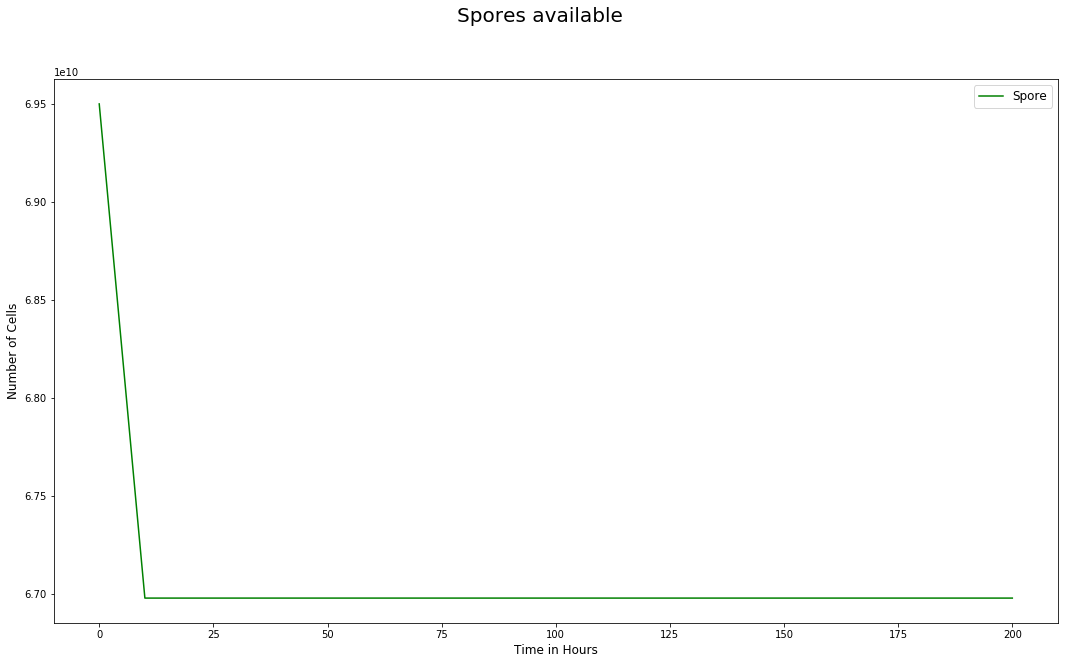

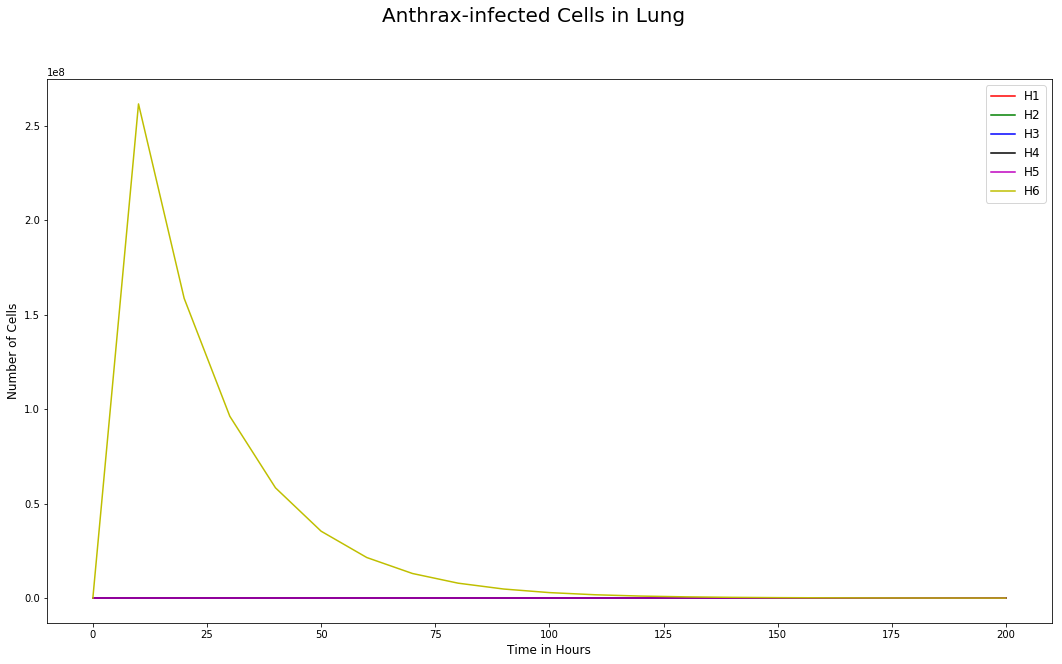

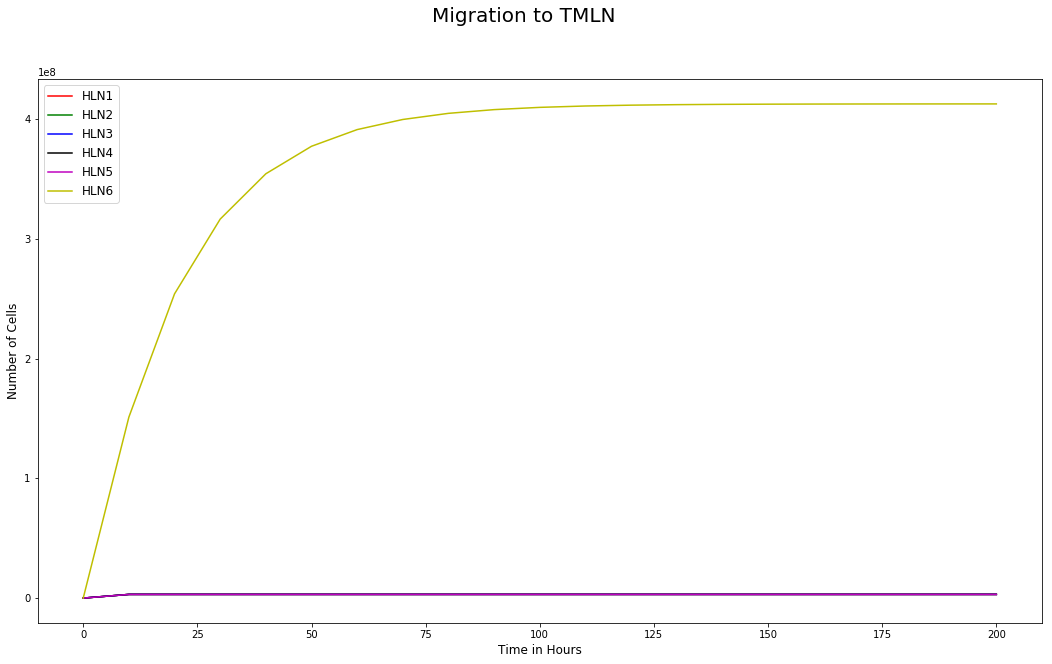

In [4]:
################################ ODEINT METHOD ##############################

# VALID (UPPER LEFT SPACE)
# block at 5, 9
model_valid_UL = DayModel(macrophage=4.28e8, spore=6.95e10)
%time results_valid_UL = model_valid_UL.run(solver=BasicODESolver)
%time mean_of_model_valid_UL = get_mean(results_valid_UL[0])
#print(results_valid_UL[0])
print(mean_of_model_valid_UL)

res = results_valid_UL[0]

data = [
    res['HLN1'][-1],
    res['HLN2'][-1],
    res['HLN3'][-1],
    res['HLN4'][-1],
    res['HLN5'][-1],
    res['HLN6'][-1]
]
x = [1,2,3,4,5,6]

mean = get_mean(res)
sd = get_std(res)
sem = get_sem(res)

plt.bar(x,data)
plt.xlabel('HLN')
plt.ylabel('Count')
plt.show()

### SPORES AVAILABLE ###

fig = plt.figure(figsize=(18,10))
fig.suptitle("Spores available", fontsize=20)

plt.plot(res['time'], res['S_'], 'g-', label='Spore')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

### HOSTS IN LUNG ###
fig = plt.figure(figsize=(18,10))
fig.suptitle("Anthrax-infected Cells in Lung", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Spore')
plt.plot(res['time'], res['H1'], 'r-', label='H1')
plt.plot(res['time'], res['H2'], 'g-', label='H2')
plt.plot(res['time'], res['H3'], 'b-', label='H3')
plt.plot(res['time'], res['H4'], 'k-', label='H4')
plt.plot(res['time'], res['H5'], 'm-', label='H5')
plt.plot(res['time'], res['H6'], 'y-', label='H6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

### TMLN MIGRATION ###
fig = plt.figure(figsize=(18,10))
fig.suptitle("Migration to TMLN", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'b', label='Spores')
plt.plot(res['time'], res['HLN1'], 'r-', label='HLN1')
plt.plot(res['time'], res['HLN2'], 'g-', label='HLN2')
plt.plot(res['time'], res['HLN3'], 'b-', label='HLN3')
plt.plot(res['time'], res['HLN4'], 'k-', label='HLN4')
plt.plot(res['time'], res['HLN5'], 'm-', label='HLN5')
plt.plot(res['time'], res['HLN6'], 'y-', label='HLN6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.show()

[[ 6.95000000e+10  6.69782412e+10  6.69782412e+10  6.69782412e+10
   6.69782412e+10  6.69782412e+10  6.69782412e+10  6.69782412e+10
   6.69782412e+10  6.69782412e+10  6.69782412e+10  6.69782412e+10
   6.69782412e+10  6.69782412e+10  6.69782412e+10  6.69782412e+10
   6.69782412e+10  6.69782412e+10  6.69782412e+10  6.69782412e+10]
 [ 4.28000000e+08 -1.36639312e-09  1.27940627e-15 -3.77941674e-17
  -6.07022248e-18  8.78598648e-19 -7.26975293e-20  1.69489299e-20
  -1.90528563e-21  7.76920224e-22 -1.68657689e-22  5.66807110e-23
  -4.68290564e-24  3.94096639e-24 -2.72189829e-25  1.88493946e-25
   1.01960800e-26 -2.22664205e-27  6.16311368e-27 -1.74328181e-27]
 [ 0.00000000e+00 -1.28707724e-08 -1.84419080e-13  2.23992788e-14
   1.02881683e-14 -3.73634379e-15  8.05021189e-16 -4.55617367e-16
   1.31749318e-16 -1.30033828e-16  7.32050447e-17 -5.90299131e-17
   1.29119537e-17 -2.55190994e-17  4.79950460e-18 -7.58944820e-18
  -8.13232272e-19  5.62042446e-19 -3.72752833e-18  2.72225359e-18]
 [ 0.00

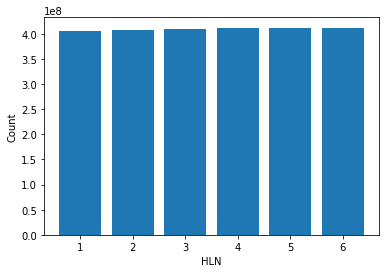

ValueError: x and y must have same first dimension, but have shapes (20,) and (14,)

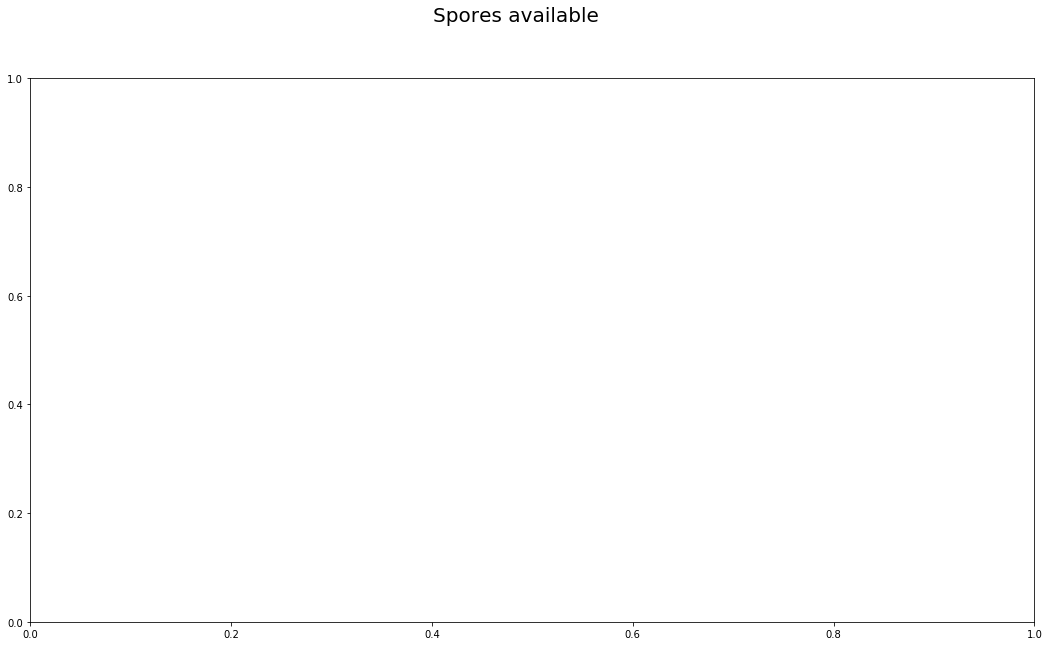

In [5]:
################################# SOLVE_IVP METHOD #########################

# VALID (UPPER LEFT SPACE)
# block at 5, 9
model_valid_UL = DayModel(macrophage=4.28e8, spore=6.95e10)
%time results_valid_UL = model_valid_UL.run(solver=BasicIVPSolver)
%time mean_of_model_valid_UL = get_mean(results_valid_UL[0])
print(mean_of_model_valid_UL)

res = results_valid_UL[0]

data = [
    res['HLN1'][-1],
    res['HLN2'][-1],
    res['HLN3'][-1],
    res['HLN4'][-1],
    res['HLN5'][-1],
    res['HLN6'][-1]
]
x = [1,2,3,4,5,6]

mean = get_mean(res)
sd = get_std(res)
sem = get_sem(res)

plt.bar(x,data)
plt.xlabel('HLN')
plt.ylabel('Count')
plt.show()

### SPORES AVAILABLE ###

fig = plt.figure(figsize=(18,10))
fig.suptitle("Spores available", fontsize=20)

plt.plot(res['time'], res['S_'], 'g-', label='Spore')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

### HOSTS IN LUNG ###
fig = plt.figure(figsize=(18,10))
fig.suptitle("Anthrax-infected Cells in Lung", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Spore')
plt.plot(res['time'], res['H1'], 'r-', label='H1')
plt.plot(res['time'], res['H2'], 'g-', label='H2')
plt.plot(res['time'], res['H3'], 'b-', label='H3')
plt.plot(res['time'], res['H4'], 'k-', label='H4')
plt.plot(res['time'], res['H5'], 'm-', label='H5')
plt.plot(res['time'], res['H6'], 'y-', label='H6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

### TMLN MIGRATION ###
fig = plt.figure(figsize=(18,10))
fig.suptitle("Migration to TMLN", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'b', label='Spores')
plt.plot(res['time'], res['HLN1'], 'r-', label='HLN1')
plt.plot(res['time'], res['HLN2'], 'g-', label='HLN2')
plt.plot(res['time'], res['HLN3'], 'b-', label='HLN3')
plt.plot(res['time'], res['HLN4'], 'k-', label='HLN4')
plt.plot(res['time'], res['HLN5'], 'm-', label='HLN5')
plt.plot(res['time'], res['HLN6'], 'y-', label='HLN6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.show()

Wall time: 149 ms
Wall time: 0 ns
1.0943758845030915


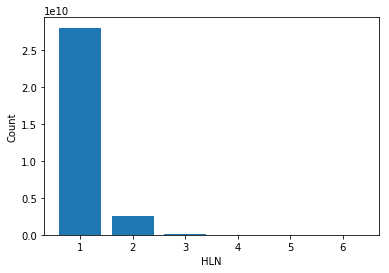

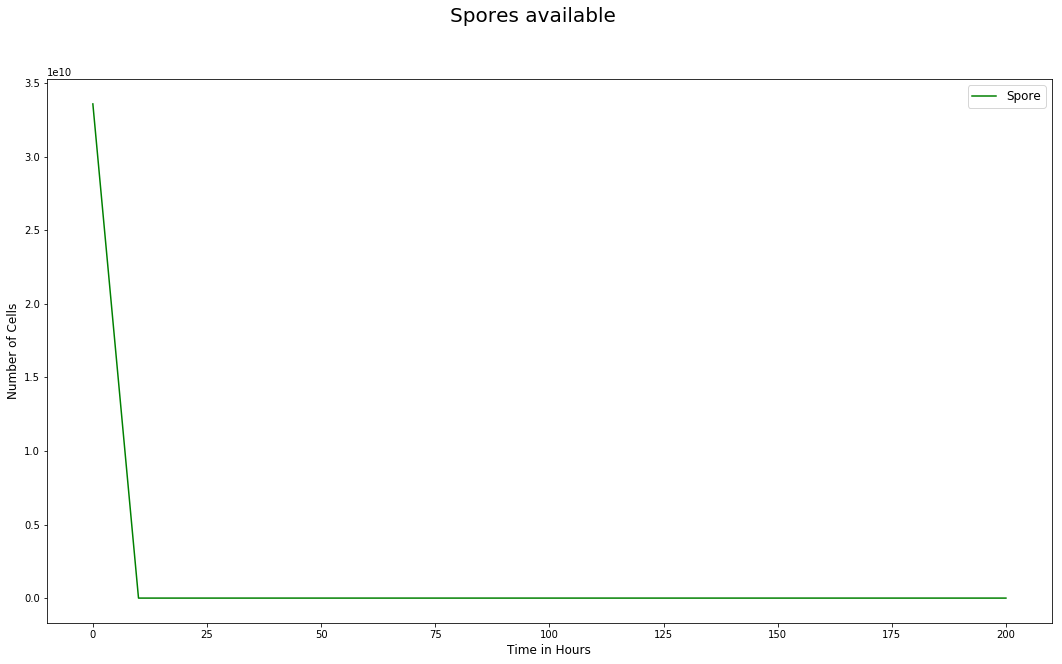

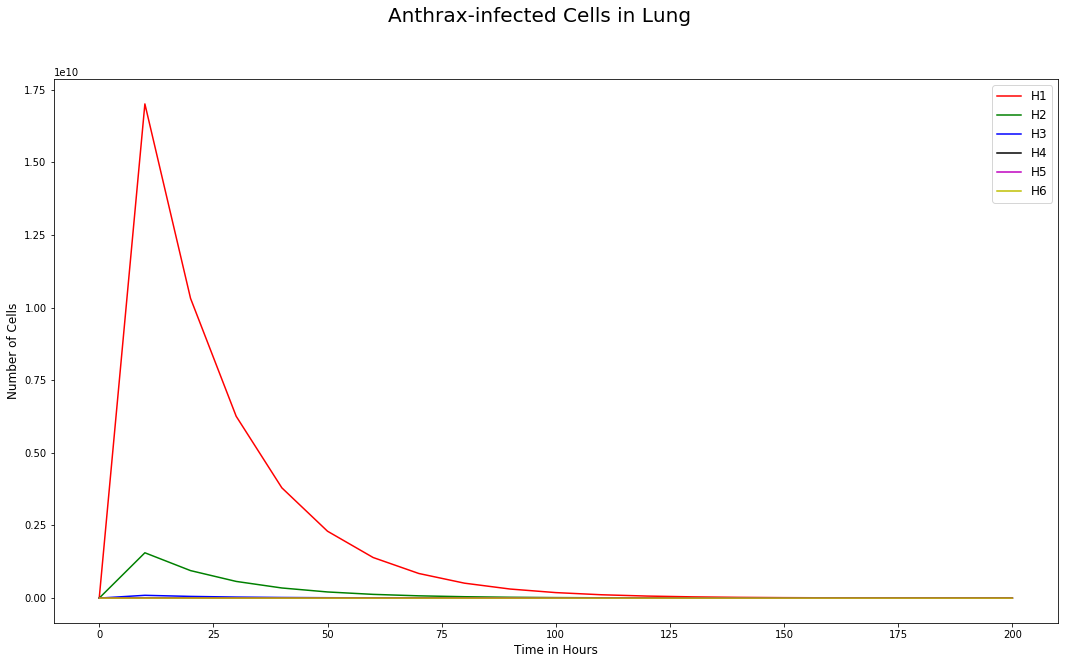

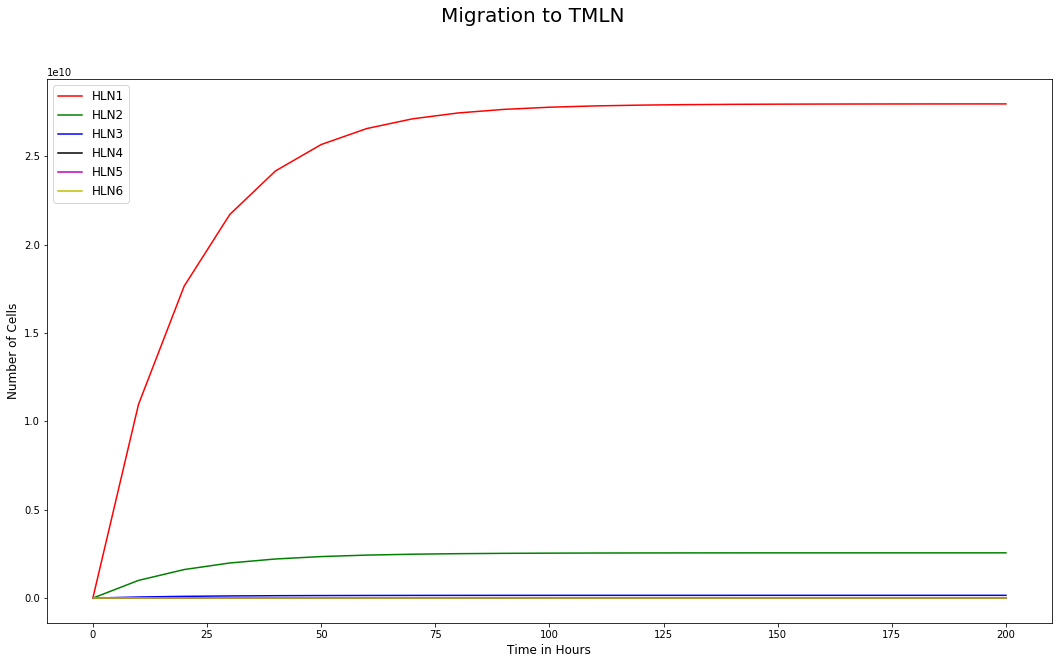

In [6]:
# VALID (LOWER RIGHT SPACE)
# block at 10, 8
model_valid_LR = DayModel(macrophage=1.83E11, spore=3.36E10)
%time results_valid_LR = model_valid_LR.run(solver=BasicODESolver)
%time mean_of_model_valid_LR = get_mean(results_valid_LR[0])
print(mean_of_model_valid_LR)
res = results_valid_LR[0]

data = [
    res['HLN1'][-1],
    res['HLN2'][-1],
    res['HLN3'][-1],
    res['HLN4'][-1],
    res['HLN5'][-1],
    res['HLN6'][-1]
]
x = [1,2,3,4,5,6]

mean = get_mean(res)
sd = get_std(res)
sem = get_sem(res)

plt.bar(x,data)
plt.xlabel('HLN')
plt.ylabel('Count')
plt.show()

### SPORES AVAILABLE ###

fig = plt.figure(figsize=(18,10))
fig.suptitle("Spores available", fontsize=20)

plt.plot(res['time'], res['S_'], 'g-', label='Spore')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

### HOSTS IN LUNG ###
fig = plt.figure(figsize=(18,10))
fig.suptitle("Anthrax-infected Cells in Lung", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Spore')
plt.plot(res['time'], res['H1'], 'r-', label='H1')
plt.plot(res['time'], res['H2'], 'g-', label='H2')
plt.plot(res['time'], res['H3'], 'b-', label='H3')
plt.plot(res['time'], res['H4'], 'k-', label='H4')
plt.plot(res['time'], res['H5'], 'm-', label='H5')
plt.plot(res['time'], res['H6'], 'y-', label='H6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

### TMLN MIGRATION ###
fig = plt.figure(figsize=(18,10))
fig.suptitle("Migration to TMLN", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'b', label='Spores')
plt.plot(res['time'], res['HLN1'], 'r-', label='HLN1')
plt.plot(res['time'], res['HLN2'], 'g-', label='HLN2')
plt.plot(res['time'], res['HLN3'], 'b-', label='HLN3')
plt.plot(res['time'], res['HLN4'], 'k-', label='HLN4')
plt.plot(res['time'], res['HLN5'], 'm-', label='HLN5')
plt.plot(res['time'], res['HLN6'], 'y-', label='HLN6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.show()

Wall time: 84.8 ms
Wall time: 0 ns
4.405472394625981


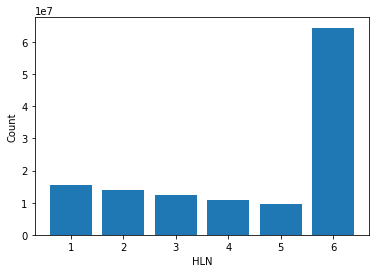

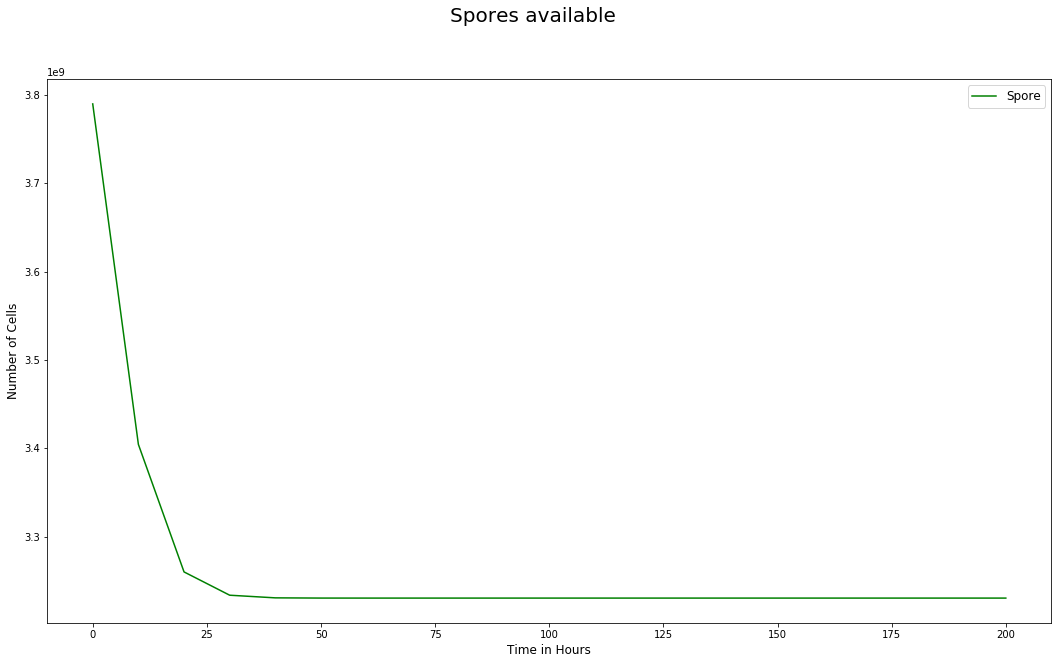

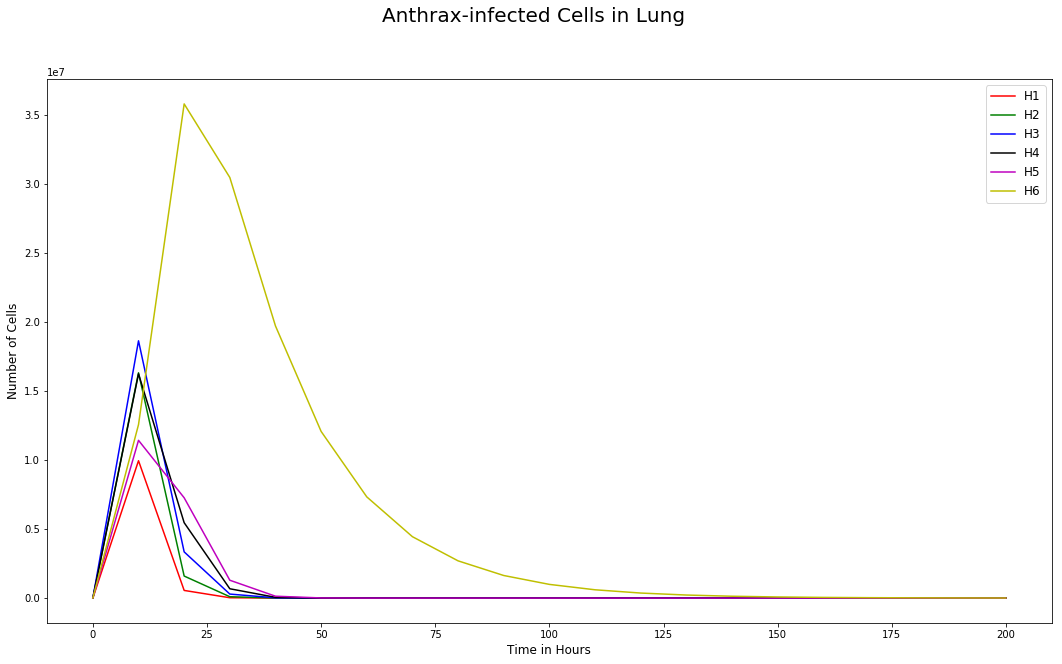

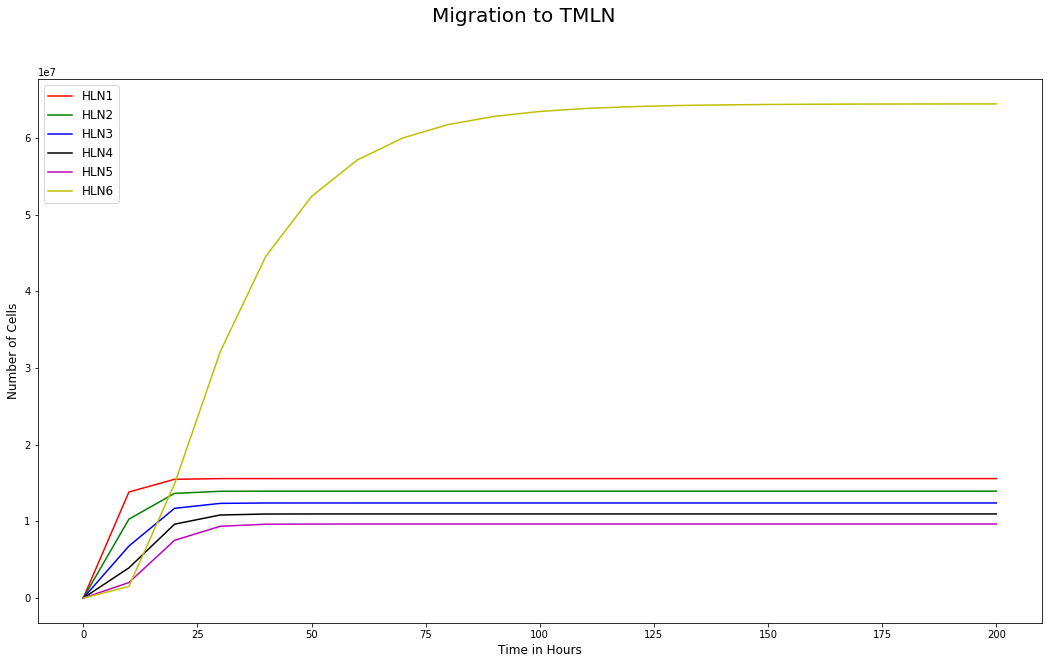

In [7]:
# VALID (LOWER RIGHT SPACE)
# block at 4, 5
model_valid_45 = DayModel(macrophage=1.27e8, spore=3.79E9)
%time results_valid_45 = model_valid_45.run(solver=BasicODESolver)
%time mean_of_model_valid_45 = get_mean(results_valid_45[0])
print(mean_of_model_valid_45)
res = results_valid_45[0]

data = [
    res['HLN1'][-1],
    res['HLN2'][-1],
    res['HLN3'][-1],
    res['HLN4'][-1],
    res['HLN5'][-1],
    res['HLN6'][-1]
]
x = [1,2,3,4,5,6]

mean = get_mean(res)
sd = get_std(res)
sem = get_sem(res)

plt.bar(x,data)
plt.xlabel('HLN')
plt.ylabel('Count')
plt.show()

### SPORES AVAILABLE ###

fig = plt.figure(figsize=(18,10))
fig.suptitle("Spores available", fontsize=20)

plt.plot(res['time'], res['S_'], 'g-', label='Spore')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

### HOSTS IN LUNG ###
fig = plt.figure(figsize=(18,10))
fig.suptitle("Anthrax-infected Cells in Lung", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Spore')
plt.plot(res['time'], res['H1'], 'r-', label='H1')
plt.plot(res['time'], res['H2'], 'g-', label='H2')
plt.plot(res['time'], res['H3'], 'b-', label='H3')
plt.plot(res['time'], res['H4'], 'k-', label='H4')
plt.plot(res['time'], res['H5'], 'm-', label='H5')
plt.plot(res['time'], res['H6'], 'y-', label='H6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

### TMLN MIGRATION ###
fig = plt.figure(figsize=(18,10))
fig.suptitle("Migration to TMLN", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'b', label='Spores')
plt.plot(res['time'], res['HLN1'], 'r-', label='HLN1')
plt.plot(res['time'], res['HLN2'], 'g-', label='HLN2')
plt.plot(res['time'], res['HLN3'], 'b-', label='HLN3')
plt.plot(res['time'], res['HLN4'], 'k-', label='HLN4')
plt.plot(res['time'], res['HLN5'], 'm-', label='HLN5')
plt.plot(res['time'], res['HLN6'], 'y-', label='HLN6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.show()

Wall time: 174 ms
Wall time: 0 ns
3.4735415841761603


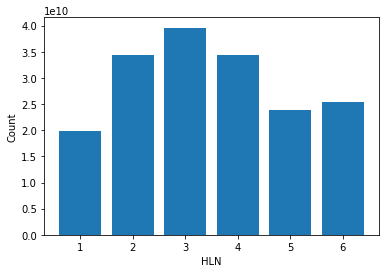

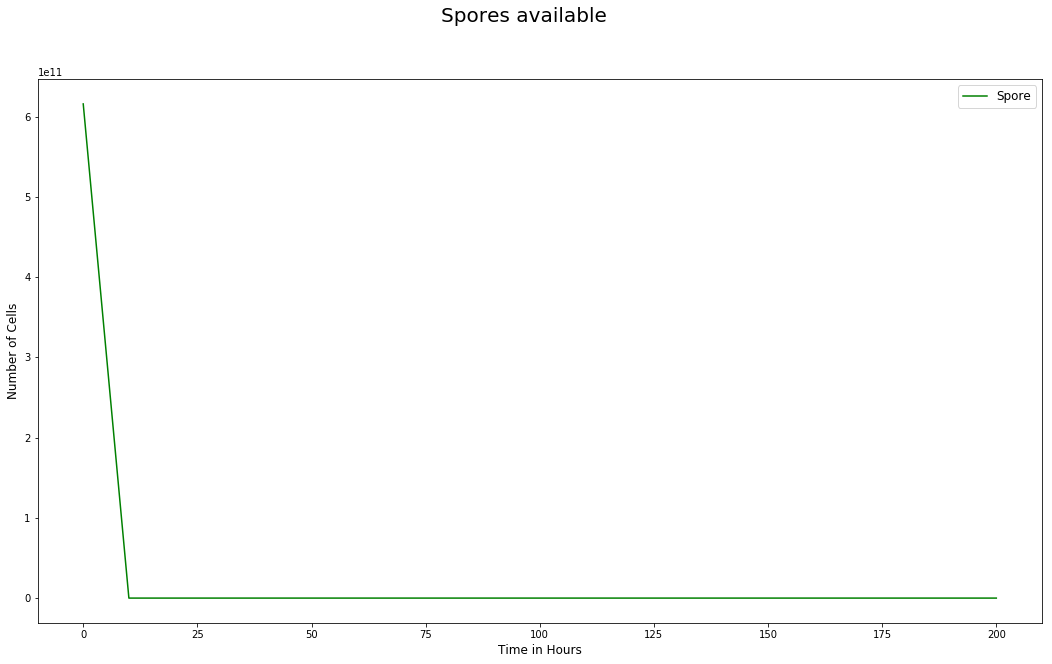

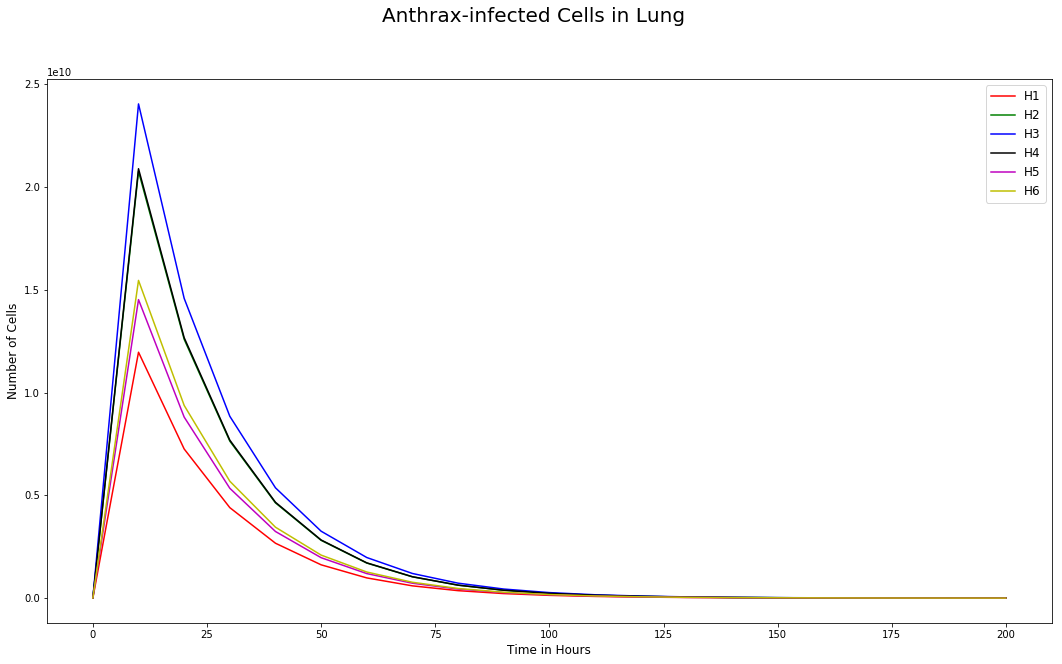

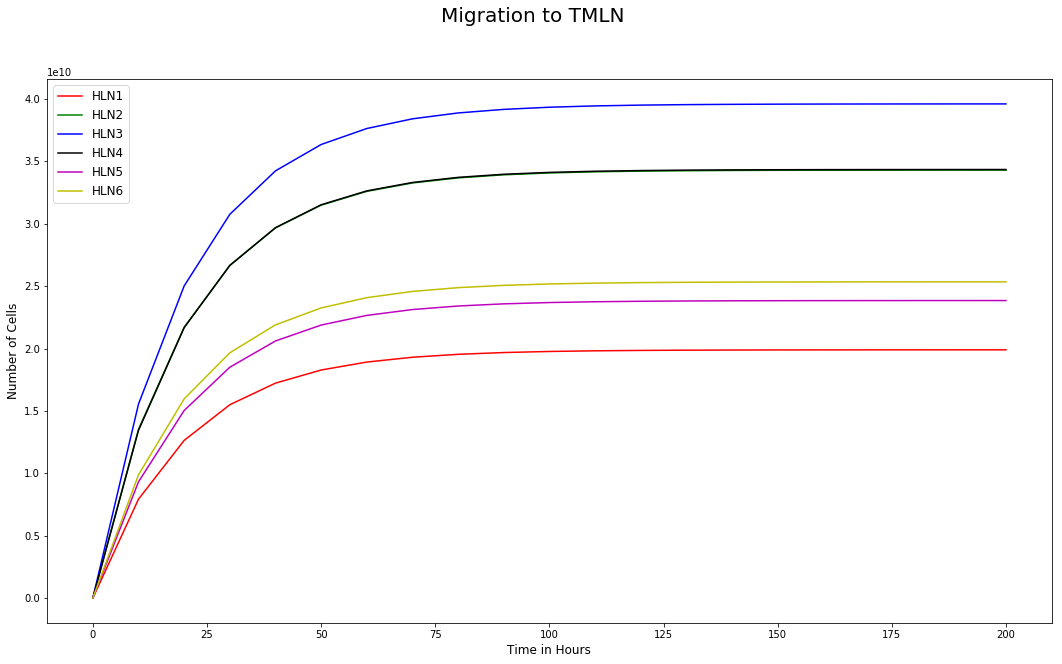

In [8]:
# ANOMALOUS block at 10, 12
model_anom = DayModel(macrophage=1.83E+11, spore=6.16E+11)
%time results_anom = model_anom.run(solver=BasicODESolver)
%time mean_of_model_anom = get_mean(results_anom[0])
print(mean_of_model_anom)
res = results_anom[0]

data = [
    res['HLN1'][-1],
    res['HLN2'][-1],
    res['HLN3'][-1],
    res['HLN4'][-1],
    res['HLN5'][-1],
    res['HLN6'][-1]
]
x = [1,2,3,4,5,6]

mean = get_mean(res)
sd = get_std(res)
sem = get_sem(res)

plt.bar(x,data)
plt.xlabel('HLN')
plt.ylabel('Count')
plt.show()

### SPORES AVAILABLE ###

fig = plt.figure(figsize=(18,10))
fig.suptitle("Spores available", fontsize=20)

plt.plot(res['time'], res['S_'], 'g-', label='Spore')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

### HOSTS IN LUNG ###
fig = plt.figure(figsize=(18,10))
fig.suptitle("Anthrax-infected Cells in Lung", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Spore')
plt.plot(res['time'], res['H1'], 'r-', label='H1')
plt.plot(res['time'], res['H2'], 'g-', label='H2')
plt.plot(res['time'], res['H3'], 'b-', label='H3')
plt.plot(res['time'], res['H4'], 'k-', label='H4')
plt.plot(res['time'], res['H5'], 'm-', label='H5')
plt.plot(res['time'], res['H6'], 'y-', label='H6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

### TMLN MIGRATION ###
fig = plt.figure(figsize=(18,10))
fig.suptitle("Migration to TMLN", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'b', label='Spores')
plt.plot(res['time'], res['HLN1'], 'r-', label='HLN1')
plt.plot(res['time'], res['HLN2'], 'g-', label='HLN2')
plt.plot(res['time'], res['HLN3'], 'b-', label='HLN3')
plt.plot(res['time'], res['HLN4'], 'k-', label='HLN4')
plt.plot(res['time'], res['HLN5'], 'm-', label='HLN5')
plt.plot(res['time'], res['HLN6'], 'y-', label='HLN6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.show()

Wall time: 183 ms
Wall time: 0 ns
5.998584536052348


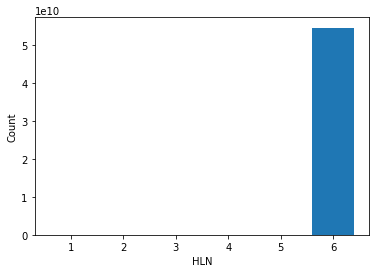

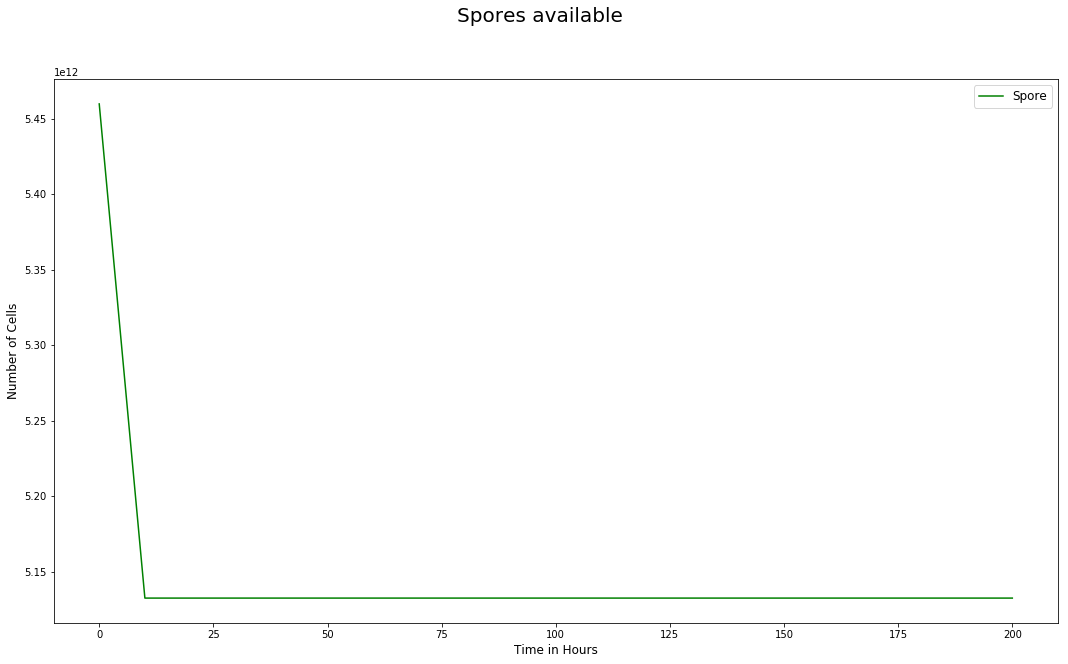

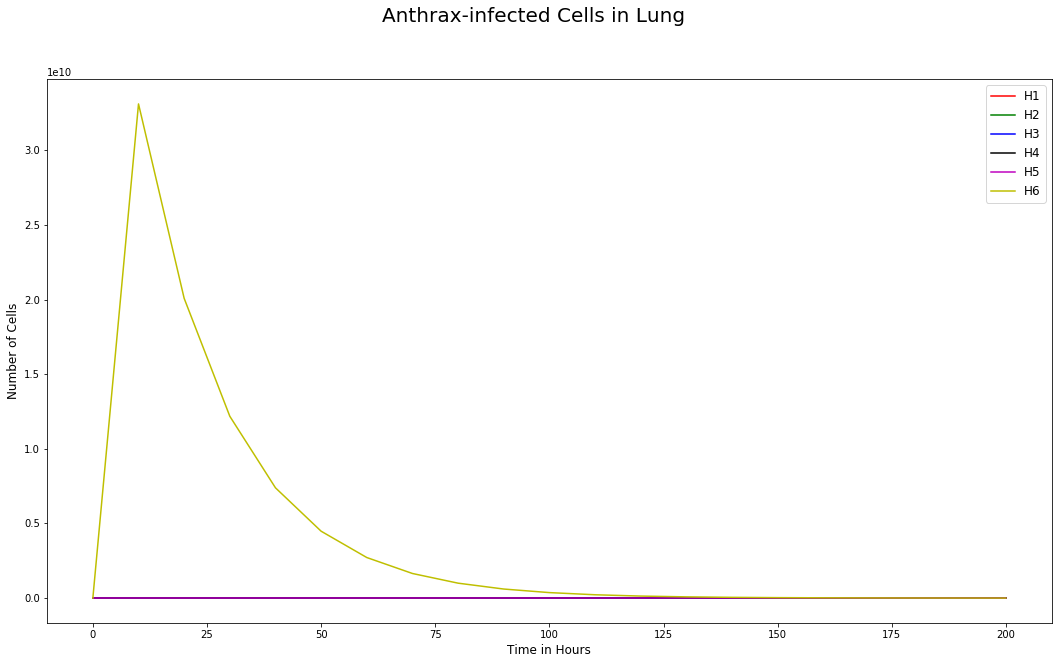

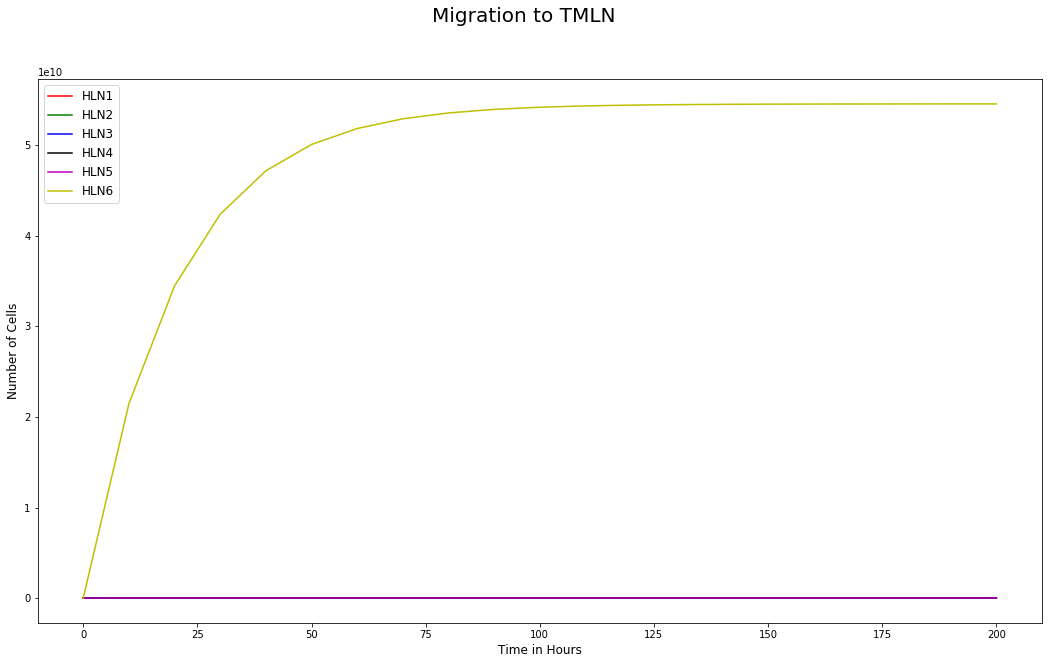

In [9]:
# ANOMALOUS in UPPER LEFT
# block at 9, 15
model_anom2 = DayModel(macrophage=5.46e10, spore=5.46e12)
%time results_anom2 = model_anom2.run(solver=BasicODESolver)
%time mean_of_model_anom2 = get_mean(results_anom2[0])
print(mean_of_model_anom2)
res = results_anom2[0]

data = [
    res['HLN1'][-1],
    res['HLN2'][-1],
    res['HLN3'][-1],
    res['HLN4'][-1],
    res['HLN5'][-1],
    res['HLN6'][-1]
]
x = [1,2,3,4,5,6]

mean = get_mean(res)
sd = get_std(res)
sem = get_sem(res)

plt.bar(x,data)
plt.xlabel('HLN')
plt.ylabel('Count')
plt.show()

### SPORES AVAILABLE ###

fig = plt.figure(figsize=(18,10))
fig.suptitle("Spores available", fontsize=20)

plt.plot(res['time'], res['S_'], 'g-', label='Spore')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

### HOSTS IN LUNG ###
fig = plt.figure(figsize=(18,10))
fig.suptitle("Anthrax-infected Cells in Lung", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Spore')
plt.plot(res['time'], res['H1'], 'r-', label='H1')
plt.plot(res['time'], res['H2'], 'g-', label='H2')
plt.plot(res['time'], res['H3'], 'b-', label='H3')
plt.plot(res['time'], res['H4'], 'k-', label='H4')
plt.plot(res['time'], res['H5'], 'm-', label='H5')
plt.plot(res['time'], res['H6'], 'y-', label='H6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

### TMLN MIGRATION ###
fig = plt.figure(figsize=(18,10))
fig.suptitle("Migration to TMLN", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'b', label='Spores')
plt.plot(res['time'], res['HLN1'], 'r-', label='HLN1')
plt.plot(res['time'], res['HLN2'], 'g-', label='HLN2')
plt.plot(res['time'], res['HLN3'], 'b-', label='HLN3')
plt.plot(res['time'], res['HLN4'], 'k-', label='HLN4')
plt.plot(res['time'], res['HLN5'], 'm-', label='HLN5')
plt.plot(res['time'], res['HLN6'], 'y-', label='HLN6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.show()

In [10]:
results_9_15

NameError: name 'results_9_15' is not defined

In [ ]:
model_10_13 = DayModel(macrophage=1.83E+11, spore=1.27E+12)
%time results_10_13 = model_10_13.run(solver=BasicODESolver)
%time mean_of_model_10_13 = get_mean(results_10_13[0])
mean_of_model_10_13

In [ ]:
model_11_14 = DayModel(macrophage=6.16E+11, spore=2.64E+12)
%time results_11_14 = model_11_14.run(solver=BasicODESolver)
%time mean_of_model_11_14 = get_mean(results_11_14[0])
mean_of_model_11_14

In [ ]:
model_11_15 = DayModel(macrophage=6.16E+11, spore=5.46E+12)
%time results_11_15 = model_11_15.run(solver=BasicODESolver)
%time mean_of_model_11_15 = get_mean(results_11_15[0])
mean_of_model_11_15

In [ ]:
model_12_16 = DayModel(macrophage=2.07E+12, spore=1.13E+13)
%time results_12_16 = model_12_16.run(solver=BasicODESolver)
%time mean_of_model_12_16 = get_mean(results_12_16[0])
mean_of_model_12_16

In [ ]:
model_13_17 = DayModel(macrophage=6.95E+12, spore=2.34E+13)
%time results_13_17 = model_13_17.run(solver=BasicODESolver)
%time mean_of_model_13_17 = get_mean(results_13_17[0])
mean_of_model_13_17

In [ ]:
model_13_18 = DayModel(macrophage=6.95E+12, spore=4.83E+13)
%time results_13_18 = model_13_18.run(solver=BasicODESolver)
%time mean_of_model_13_18 = get_mean(results_13_18[0])
mean_of_model_13_18

In [ ]:
model_14_19 = DayModel(macrophage=2.34E+13, spore=1.00E+14)
%time results_14_19 = model_14_19.run(solver=BasicODESolver)
%time mean_of_model_14_19 = get_mean(results_14_19[0])
mean_of_model_14_19

In [ ]:
# THIS IS ONE OF THE OUTLIERS
model_15_15 = DayModel(macrophage=7.85E+13, spore=5.46E+12)
%time results_15_15 = model_15_15.run(solver=BasicODESolver)
%time mean_of_model_15_15 = get_mean(results_15_15[0])
mean_of_model_15_15

In [ ]:
# THIS IS ONE OF THE OUTLIERS
model_18_18 = DayModel(macrophage=2.48E+15, spore=4.83e13)
%time results_18_18 = model_18_18.run(solver=BasicODESolver)
%time mean_of_model_18_18 = get_mean(results_18_18[0])
mean_of_model_18_18

In [ ]:
res = results_10_12[0]
data = [
    res['HLN1'][-1],
    res['HLN2'][-1],
    res['HLN3'][-1],
    res['HLN4'][-1],
    res['HLN5'][-1],
    res['HLN6'][-1]
]
x = [1,2,3,4,5,6]


mean = get_mean(res)
sd = get_std(res)
sem = get_sem(res)

plt.bar(x,data)
plt.xlabel('HLN')
plt.ylabel('Count')
plt.show()

# plt.hist(data3, bins=x,edgecolor="black")
# plt.xlabel('HLN')
# plt.ylabel('Count')
# plt.show()

print("Mean: \t{}".format(mean))
print("STD:  \t{}".format(sd))
print("SEM:  \t{}".format(sem))

In [11]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Spores available", fontsize=20)

plt.plot(results_10_12[0]['time'], results_10_12[0]['S_'], 'g-', label='Spore')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
# print("Initial spores: {}".format(results['S_'][0]))
# print("Spores remaining: {}".format(results['S_'][-1]))
# print("Spores at 5 hours: {}".format(results['S_'][100]))


NameError: name 'results_10_12' is not defined

<Figure size 1296x720 with 0 Axes>

In [12]:
res = results_10_12[0]
fig = plt.figure(figsize=(18,10))
fig.suptitle("Anthrax-infected Cells in Lung", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Spore')
plt.plot(res['time'], res['H1'], 'r-', label='H1')
plt.plot(res['time'], res['H2'], 'g-', label='H2')
plt.plot(res['time'], res['H3'], 'b-', label='H3')
plt.plot(res['time'], res['H4'], 'k-', label='H4')
plt.plot(res['time'], res['H5'], 'm-', label='H5')
plt.plot(res['time'], res['H6'], 'y-', label='H6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

print("Lung Hosts at end:")
print("H1: {}".format(res['H1'][-1]))
print("H2: {}".format(res['H2'][-1]))
print("H3: {}".format(res['H3'][-1]))
print("H4: {}".format(res['H4'][-1]))
print("H5: {}".format(res['H5'][-1]))
print("H6: {}".format(res['H6'][-1]))




NameError: name 'results_10_12' is not defined

In [13]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Migration to TMLN", fontsize=20)
res = results_10_12[0]

#plt.plot(results[0]['time'], results[0]['S_'], 'b', label='Spores')
plt.plot(res['time'], res['HLN1'], 'r-', label='HLN1')
plt.plot(res['time'], res['HLN2'], 'g-', label='HLN2')
plt.plot(res['time'], res['HLN3'], 'b-', label='HLN3')
plt.plot(res['time'], res['HLN4'], 'k-', label='HLN4')
plt.plot(res['time'], res['HLN5'], 'm-', label='HLN5')
plt.plot(res['time'], res['HLN6'], 'y-', label='HLN6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

print("k2 = {:.2e}, k3 = {:.2e}".format(float(model_10_12.listOfParameters['k2'].expression), float(model_10_12.listOfParameters['k3'].expression)))

print("Lung Hosts at end:")
print("H1: {}".format(res['H1'][-1]))
print("H2: {}".format(res['H2'][-1]))
print("H3: {}".format(res['H3'][-1]))
print("H4: {}".format(res['H4'][-1]))
print("H5: {}".format(res['H5'][-1]))
print("H6: {}".format(res['H6'][-1]))

print("Lymph Node Hosts at end:")
print("HLN1: {}".format(res['HLN1'][-1]))
print("HLN2: {}".format(res['HLN2'][-1]))
print("HLN3: {}".format(res['HLN3'][-1]))
print("HLN4: {}".format(res['HLN4'][-1]))
print("HLN5: {}".format(res['HLN5'][-1]))
print("HLN6: {}".format(res['HLN6'][-1]))

NameError: name 'results_10_12' is not defined

<Figure size 1296x720 with 0 Axes>